Number of unique customers:5191

Unique categories:['Clothing' 'Shoes' 'Books' 'Cosmetics' 'Food & Beverage' 'Toys'
 'Technology' 'Souvenir']
Number of unique categories:8

Most popular payment method:Cash, used 44447 times


Top 3 categories by total sales: 
Clothing: 113,996,791.04

Shoes: 66,553,451.47

Technology: 57,862,350.00

Total sales from customers over age 45: $82,053,156.99


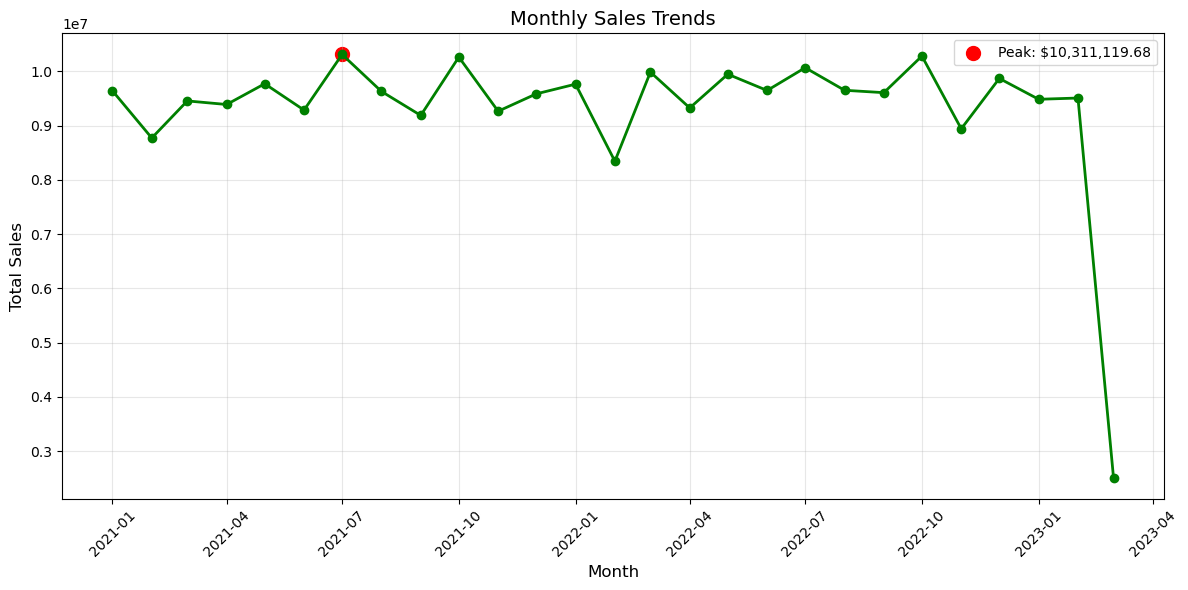



Sales Breakdown by Category and Age Range:


age_range,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80-89,Total
category,,,,,,,,,
Books,"$12,635.10","$77,007.45","$83,446.20","$86,173.20","$75,204.60","$80,658.60","$55,418.70","$26,330.70","$496,874.55"
Clothing,"$1,893,504.80","$10,107,594.64","$11,217,890.64","$11,233,194.72","$10,461,689.04","$10,607,828.00","$7,691,950.64","$4,479,894.32","$67,693,546.80"
Cosmetics,"$110,757.84","$594,205.24","$718,950.12","$660,562.36","$592,456.86","$646,331.36","$416,886.98","$247,944.68","$3,988,095.44"
Food & Beverage,"$13,320.81","$73,345.52","$86,587.88","$88,292.86","$72,153.08","$81,164.37","$54,805.17","$31,359.08","$501,028.77"
Shoes,"$1,024,490.19","$5,909,273.82","$7,095,209.74","$6,994,981.35","$5,834,252.57","$5,968,090.48","$4,488,671.43","$2,666,555.31","$39,981,524.89"
Souvenir,"$12,034.98","$55,013.70","$63,342.00","$64,984.20","$55,905.18","$55,893.45","$38,873.22","$22,545.06","$368,591.79"
Technology,"$1,129,800.00","$5,325,600.00","$6,015,450.00","$5,911,500.00","$4,437,300.00","$5,429,550.00","$3,697,050.00","$1,988,700.00","$33,934,950.00"
Toys,"$59,136.00","$380,835.84","$421,191.68","$388,398.08","$343,633.92","$363,991.04","$271,380.48","$151,961.60","$2,380,528.64"
Total,"$4,255,679.72","$22,522,876.21","$25,702,068.26","$25,428,086.77","$21,872,595.25","$23,233,507.30","$16,715,036.62","$9,615,290.75","$149,345,140.88"


In [118]:
import pandas as pd

invoice = pd.read_csv('fct_invoice.csv')

#Easy #1. How many unique customers
unique_customers = invoice['customer_id'].nunique()
print(f'Number of unique customers:{unique_customers}\n')

#Easy #2. What are the unique values in product_category and count
categories = invoice['category'].unique()
num_categories = len(categories)
print(f'Unique categories:{categories}')
print(f'Number of unique categories:{num_categories}\n')

#Easy #3. Most popular payment method
count_payment = invoice['payment_method'].value_counts()
most_popular = count_payment.idxmax()
times_used = count_payment.max()
print(f'Most popular payment method:{most_popular}, used {times_used} times\n\n')

#Medium #1. 3 most popular categories by total sales (quantity * price)
#Group by category and sum the sales
invoice['total_sales'] = invoice['quantity'] * invoice['price']
category_sales = invoice.groupby('category')['total_sales'].sum().sort_values(ascending=False)

#Top 3 
print("Top 3 categories by total sales: ")
for category, sales in category_sales.head(3).items():
    print(f'{category}: {sales:,.2f}\n')                                 #^ change the formatting. else could be written as 
                                                                        #top_3_cat = category_sales.head(3)
                                                                        #print("Top 3 categories by total sales (quantity × price):")                                                                                                                                    #print(top_3_cat)
#Medium #2. Total sales from customers over age 45
import numpy as np
import json

# 1. Load the customer data
with open("dim_customer.json", "r") as f:
    customer_data = json.load(f)

# 2. Create DataFrame 
age_data = customer_data.get('age', {})
customer_df = pd.DataFrame.from_dict(age_data, orient='index', columns=['age'])
customer_df = customer_df.reset_index().rename(columns={'index': 'customer_id'})

# Check if values are numeric/empty and convert data types
customer_df['customer_id'] = pd.to_numeric(customer_df['customer_id'], errors='coerce')
customer_df['age'] = pd.to_numeric(customer_df['age'], errors='coerce')
customer_df = customer_df.dropna(subset=['customer_id'])
customer_df['customer_id'] = customer_df['customer_id'].astype(int)

#Load invoice data
invoice = pd.read_csv("fct_invoice.csv")
invoice['customer_id'] = pd.to_numeric(invoice['customer_id'], errors='coerce')
invoice = invoice.dropna(subset=['customer_id'])
invoice['customer_id'] = invoice['customer_id'].astype(int)

#Calculate total sales 
invoice['total_sales'] = invoice['quantity'] * invoice['price']

#Merge data
merged_df = pd.merge(invoice, customer_df, on='customer_id', how='inner')

#Filter for customers over 45 and calculate total sales
result = merged_df[merged_df['age'] > 45]['total_sales'].sum()

print(f"Total sales from customers over age 45: ${result:,.2f}")

#Medium 3. Sales Distribution across invoice dates
import matplotlib.pyplot as plt

#Calculate total sales
invoice['total_sales'] = invoice['quantity'] * invoice['price']

#Convert and check date to Day-Month format
invoice['invoice_date'] = pd.to_datetime(invoice['invoice_date'],dayfirst=True)

#Aggregate sales and date
invoice ['year_month'] = invoice['invoice_date'].dt.to_period('M')
monthly_sales = invoice.groupby('year_month')['total_sales'].sum().reset_index()
monthly_sales['year_month'] = monthly_sales['year_month'].dt.to_timestamp()

#plotting
plt.figure(figsize=(12,6))
plt.plot(monthly_sales['year_month'],monthly_sales['total_sales'],
         marker='o',color='green',linestyle='-',linewidth=2)
plt.title('Monthly Sales Trends',fontsize=14)
plt.xlabel('Month',fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.grid(True,alpha=0.3)
plt.xticks(rotation=45)

#emphasize max
max_sales=monthly_sales['total_sales'].max()
peak_months = monthly_sales[monthly_sales['total_sales'] == max_sales]
plt.scatter(peak_months['year_month'],peak_months['total_sales'],
            color = 'red',s=100, label = f'Peak: ${max_sales:,.2f}')

plt.legend()
plt.tight_layout()
plt.show()

#Hard. Pivot table of the sales breakdown across diff. dimensions
def create_sales_pivot_table(customer_json_path, invoice_csv_path):
    with open(customer_json_path, "r") as f: #process customer data
        customer_data = json.load(f)
    
    customer_df = (
        pd.DataFrame.from_dict(customer_data['age'], orient='index', columns=['age'])
        .reset_index()
        .rename(columns={'index': 'customer_id'})
    )
    
    # Clean customer data to make sure all values are numeric and group by age (20,30,...)
    customer_df = (
        customer_df.assign(
            customer_id=lambda x: pd.to_numeric(x['customer_id'], errors='coerce'),
            age=lambda x: pd.to_numeric(x['age'], errors='coerce'),
            age_decade=lambda x: np.floor(x['age']/10)*10  # Create decade groups
        )
        .dropna(subset=['customer_id', 'age_decade'])
        .astype({'customer_id': 'int', 'age_decade': 'int'})
    )
    
    # process invoice data
    invoice = (
        pd.read_csv(invoice_csv_path)
        .assign(
            customer_id=lambda x: pd.to_numeric(x['customer_id'], errors='coerce'),
            total_sales=lambda x: x['quantity'] * x['price']
        )
        .dropna(subset=['customer_id'])
        .astype({'customer_id': 'int'})
    )
    
    # Merge data and create pivot table
    merged_df = pd.merge(invoice, customer_df, on='customer_id', how='inner')
    
    # Create age labels (e.g., "20-29")
    merged_df['age_range'] = (
        merged_df['age_decade'].astype(str) + '-' + 
        (merged_df['age_decade']+9).astype(str)
    )
    
    # Creating pivot table
    pivot_table = pd.pivot_table(
        merged_df,
        values='total_sales',
        index='category',
        columns='age_range',
        aggfunc='sum',
        fill_value=0,
        margins=True,
        margins_name='Total'
    )
    
    # Format the output
    pivot_table = pivot_table.style.format("${:,.2f}")
    
    return pivot_table

# to show the pivot table
if __name__ == "__main__":
    pivot = create_sales_pivot_table("dim_customer.json", "fct_invoice.csv")
    print("\n\nSales Breakdown by Category and Age Range:")
    display(pivot)
